# This is for CS543 MP2
Name: Luning Wang    Netid: luningw2

# Part 2: Scale-space blob detection

In [1]:
import os
import sys
import glob
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
from skimage.feature import peak_local_max
from matplotlib.patches import Circle
from skimage import color, io, transform
import scipy
from scipy.ndimage.filters import gaussian_laplace, rank_filter
from PIL import Image

In [2]:
def create_filter(img, sig):
    filters = sig * sig * gaussian_laplace(img, sigma = sig)
    return filters

def create_filter_DoG(img, sig):
    filtered1 = gaussian_laplace(img, sigma = sig)
    sig2 = sig * 1.25
    filtered2 = gaussian_laplace(img, sigma = sig2)
    filters = filtered1 - filtered2
    return filters

def readimg(imgname):
    dirs = "assignment2_images/"
    img = color.rgb2gray(io.imread(dirs + imgname)).astype(float)
    return img

def show_all_circles(image, cx, cy, rad, color='r'):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)
    
    plt.title('%i circles' % len(cx))
    plt.show()

### mode 0 is inefficient by enlarging filter size
### mode 1 is efficient by downsampling images
### mode 2 is DoG method

In [3]:
def blob_detect(imgname, sig, n, threshold, mode):
    img = readimg(imgname)
    h, w = np.shape(img)
    scale_space = np.zeros((h, w, n))
    max_scale_space = np.zeros((h, w, n))

    k = 1.25 # scaling factor

    # do nonmaxima suppression for each layer
    start_time = time.time()

    if mode == 0:
        for i in range(0, n):
            # new sigma makes new window size
            newsig = sig * k ** (i)
            filtered_img = create_filter(img, newsig)
            scale_space[:, :, i] = np.power(filtered_img, 2)
            max_scale_space[:, :, i] = rank_filter(scale_space[:, :, i], rank = -1, size = (5, 5))

    if mode == 1:
        for i in range(0, n):
            scaling_factor = 1.0 / (k ** i)
            downsampled_img = transform.resize(img, (int(scaling_factor * h), int(scaling_factor * w)), anti_aliasing=True)
            filtered_img = create_filter(downsampled_img, sig)
            upsampled_img = transform.resize(np.power(filtered_img, 2), (h, w),  anti_aliasing=True)
            scale_space[:, :, i] = upsampled_img;
            max_scale_space[:, :, i] = rank_filter(scale_space[:, :, i], rank = -1, size = (5, 5))

    if mode == 2:
        for i in range(0, n):
            scaling_factor = 1.0 / (k ** i)
            downsampled_img = transform.resize(img, (int(scaling_factor * h), int(scaling_factor * w)), anti_aliasing=True)
            filtered_img = create_filter_DoG(downsampled_img, sig)
            filtered_img = filtered_img / (k - 1)
            upsampled_img = transform.resize(np.power(filtered_img, 2), (h, w),  anti_aliasing=True)
            scale_space[:, :, i] = upsampled_img;
            max_scale_space[:, :, i] = rank_filter(scale_space[:, :, i], rank = -1, size = (5, 5))

    compare_scale_space = np.zeros((h, w, n))
    for i in range(0, h):
        for j in range(0, w):
            max_value = max(max_scale_space[i, j, :])
            #print (max_scale_space[i, j, :])
            #print (max_value)
            max_index = np.where(max_scale_space[i, j, :] == max_value)[0][0]
            #print (max_index)
            if max_value >= threshold and max_value == scale_space[i, j, max_index]:
                compare_scale_space[i, j, max_index] = max_value;

    cx = []
    cy = []
    radius = []
    for layer in range(0, n):
        for i in range(0, h):
            for j in range(0, w):
                if compare_scale_space[i, j, layer] != 0:
                    cx.append(j)
                    cy.append(i)
                    blob_radius = 1.414 * sig * k ** layer
                    radius.append(blob_radius)

    print("--- %s time elapsed ---" % (time.time() - start_time))
    show_all_circles(img, cx, cy, radius)

In [4]:
### this is the 4 sample images given in hw

--- 2.273599863052368 time elapsed ---


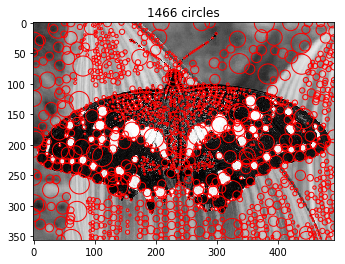

/Users/wangluning/miniconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


--- 1.9432101249694824 time elapsed ---


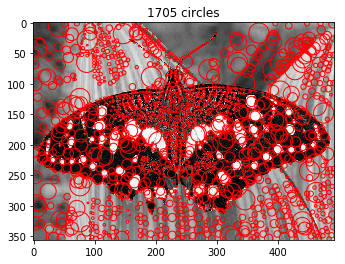

--- 2.1917359828948975 time elapsed ---


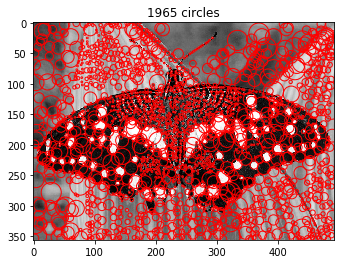

In [5]:
blob_detect('butterfly.jpg', 1.0, 12, 0.002, 0)
blob_detect('butterfly.jpg', 1.0, 12, 0.002, 1)
blob_detect('butterfly.jpg', 1.0, 12, 0.003, 2)

--- 3.7057228088378906 time elapsed ---


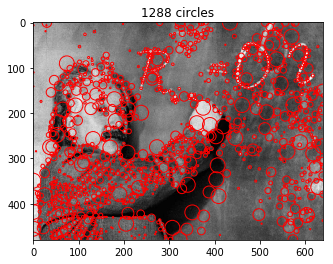

--- 3.331803798675537 time elapsed ---


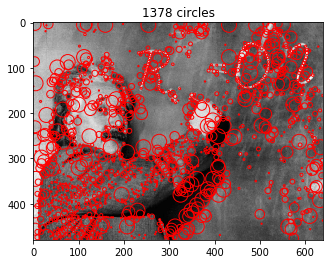

--- 3.809246063232422 time elapsed ---


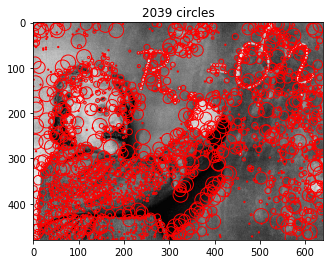

In [6]:
blob_detect('einstein.jpg', 1.0, 12, 0.002, 0)
blob_detect('einstein.jpg', 1.0, 12, 0.002, 1)
blob_detect('einstein.jpg', 1.0, 12, 0.003, 2)

--- 2.0855681896209717 time elapsed ---


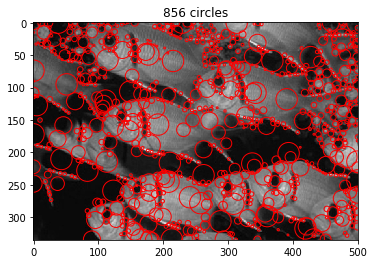

--- 2.067908763885498 time elapsed ---


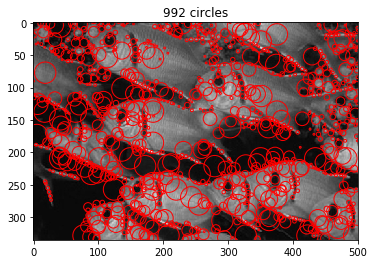

--- 1.859471321105957 time elapsed ---


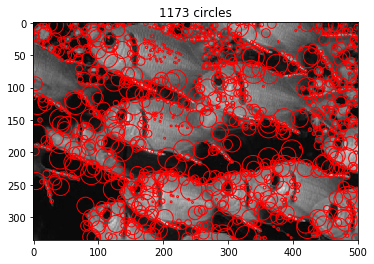

In [7]:
blob_detect('fishes.jpg', 1.0, 12, 0.002, 0)
blob_detect('fishes.jpg', 1.0, 12, 0.002, 1)
blob_detect('fishes.jpg', 1.0, 12, 0.003, 2)

--- 1.3527233600616455 time elapsed ---


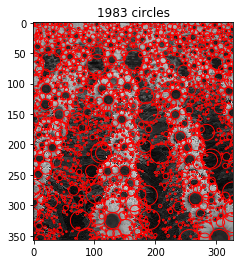

--- 1.304069995880127 time elapsed ---


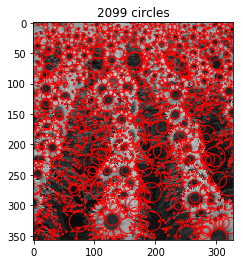

--- 1.3112828731536865 time elapsed ---


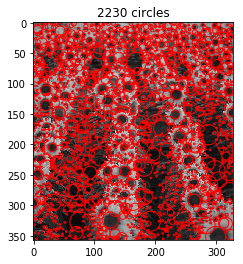

In [8]:
blob_detect('sunflowers.jpg', 1.0, 12, 0.002, 0)
blob_detect('sunflowers.jpg', 1.0, 12, 0.002, 1)
blob_detect('sunflowers.jpg', 1.0, 12, 0.003, 2)

--- 11.167357921600342 time elapsed ---


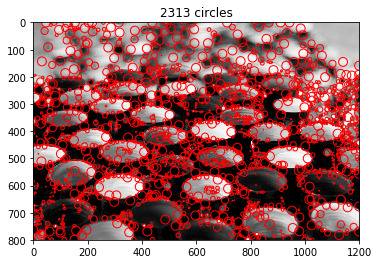

--- 11.505367994308472 time elapsed ---


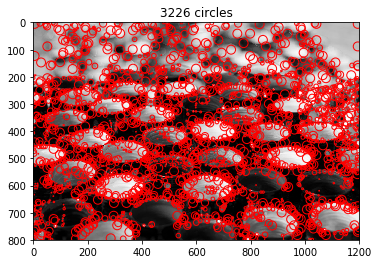

--- 10.801634073257446 time elapsed ---


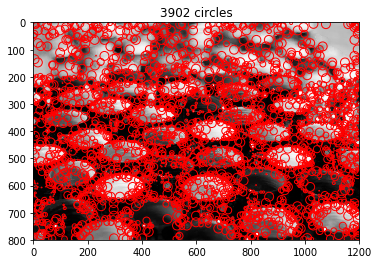

In [9]:
blob_detect('cups.jpg', 1.0, 12, 0.002, 0)
blob_detect('cups.jpg', 1.0, 12, 0.002, 1)
blob_detect('cups.jpg', 1.0, 12, 0.003, 2)

--- 0.620293140411377 time elapsed ---


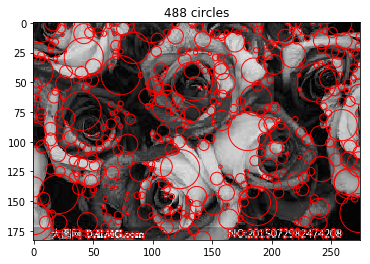

--- 0.5998489856719971 time elapsed ---


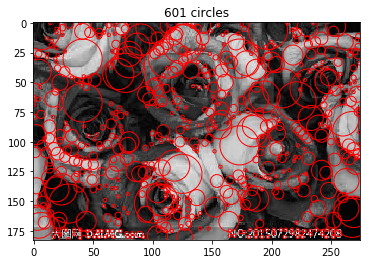

--- 0.6513328552246094 time elapsed ---


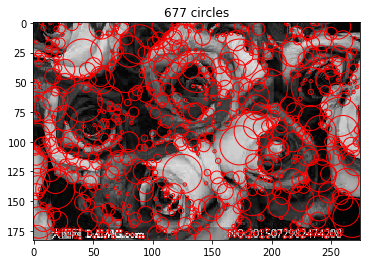

In [10]:
blob_detect('papers.jpg', 1.0, 12, 0.001, 0)
blob_detect('papers.jpg', 1.0, 12, 0.001, 1)
blob_detect('papers.jpg', 1.0, 12, 0.001, 2)

--- 0.6305060386657715 time elapsed ---


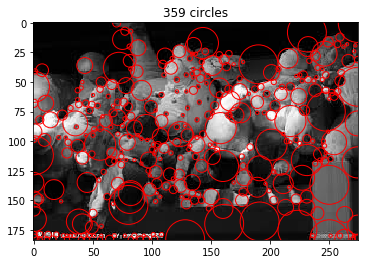

--- 0.592860221862793 time elapsed ---


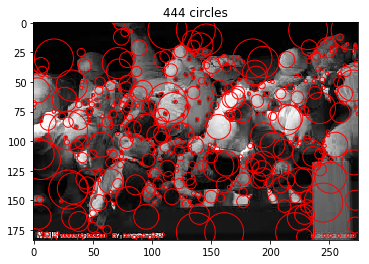

--- 0.6473429203033447 time elapsed ---


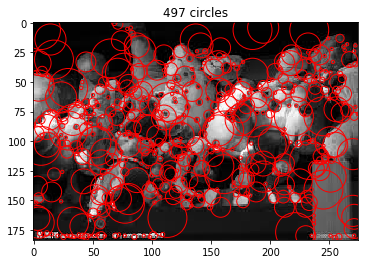

In [11]:
blob_detect('toys.jpg', 1.0, 12, 0.001, 0)
blob_detect('toys.jpg', 1.0, 12, 0.001, 1)
blob_detect('toys.jpg', 1.0, 12, 0.001, 2)

--- 0.6531579494476318 time elapsed ---


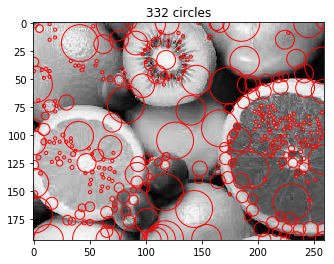

--- 0.6067461967468262 time elapsed ---


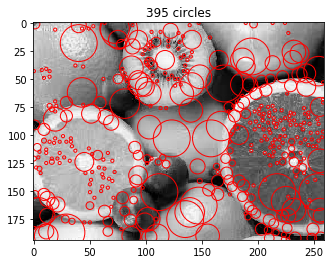

--- 0.6340060234069824 time elapsed ---


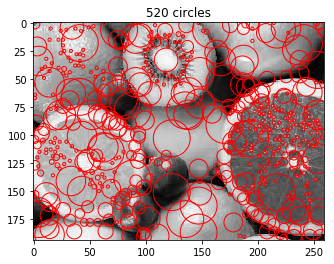

In [12]:
blob_detect('fruit.jpg', 1.0, 12, 0.001, 0)
blob_detect('fruit.jpg', 1.0, 12, 0.001, 1)
blob_detect('fruit.jpg', 1.0, 12, 0.001, 2)